In [40]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.model_selection import train_test_split
sys.path.append('../../')
import Constants as c
import Utilities as utils
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn import metrics
sns.set_style("darkgrid")
%matplotlib inline

In [41]:
file = "../../output/linux_version_metrics.csv"
df = pd.read_csv(file)

df["E_Line"] = df["E_Line"].astype(str).astype(int)
df["E_Module"] = df["E_Module"].astype(str).astype(int)
df = df.rename(columns={"T_Line": "T_Line_Original", "T_Module": "T_Module_Original"})
df["T_Line"] = df["T_Line_Original"].shift()
df["T_Module"] = df["T_Module_Original"].shift()
df = df[[c.VERSION, c.NT, c.NO, "E_Line", "E_Module", c.T_LINE, c.T_MODULE]]

if df.isna().values.any():
    df.fillna(0, inplace=True)

# df = df.apply(lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) else x)
df.replace([np.inf, -np.inf], 0, inplace=True)
# df.replace(0, 1, inplace=True)
print(len(df))

638


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefdcd1ed90>,
      dtype=object)

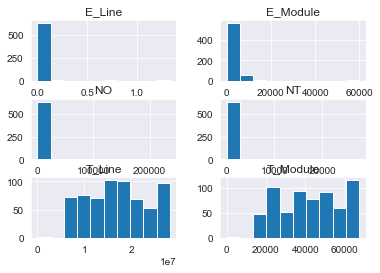

In [42]:
df.hist()

598
552
477
466


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefdcd016d0>,
      dtype=object)

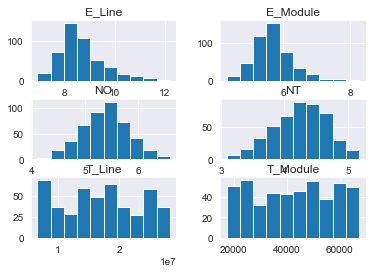

In [43]:
df["E_Line"] = utils.log_transform(df, "E_Line")
df["E_Module"] = utils.log_transform(df, "E_Module")
df[c.NT] = utils.log_transform(df, c.NT)
df[c.NO] = utils.log_transform(df, c.NO)
# df = df.apply(lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) else x)
df = utils.remove_outlier(df, "E_Line")
print(len(df))
df = utils.remove_outlier(df, "E_Module")
print(len(df))
# df = utils.remove_outlier(df, "T_Line")
# df = utils.remove_outlier(df, "T_Module")
df = utils.remove_outlier(df, c.NO)
print(len(df))
df = utils.remove_outlier(df, c.NT)
print(len(df))
df.hist()

In [44]:
# print out a correlation matrix of our data frame
corr = df.corr(method="pearson")

# display it
display(corr)

,NT,NO,E_Line,E_Module,T_Line,T_Module
NT,1.000000,0.819577,0.570529,0.731367,-0.023447,-0.030880
NO,0.819577,1.000000,0.747443,0.868089,-0.031971,-0.041129
E_Line,0.570529,0.747443,1.000000,0.848460,-0.393840,-0.407183
E_Module,0.731367,0.868089,0.848460,1.000000,-0.208759,-0.219340
T_Line,-0.023447,-0.031971,-0.393840,-0.208759,1.000000,0.998642
T_Module,-0.030880,-0.041129,-0.407183,-0.219340,0.998642,1.000000


Text(0.5, 1.0, 'Correlation Plot - Linux Project')

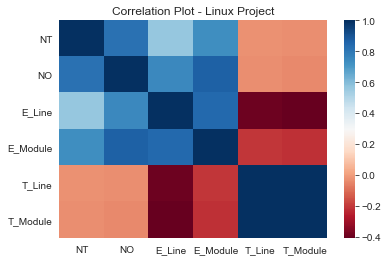

In [79]:
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
ax.set_title('Correlation Plot - Linux Project')

Text(0.5, 1.0, 'NT vs. E_Line - Linux')

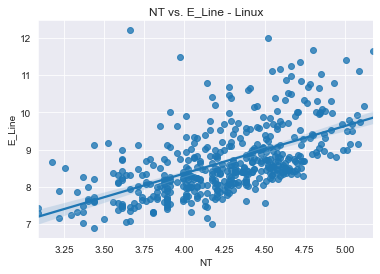

In [46]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Line", data=df)
plt.title('NT vs. E_Line - {0}'.format("Linux"))

Text(0.5, 1.0, 'NO vs. E_Line - Linux')

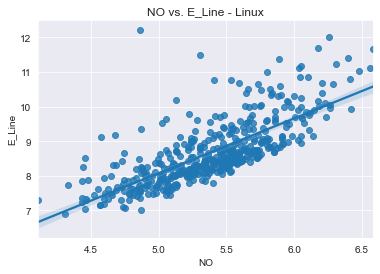

In [47]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NO, y="E_Line", data=df)
plt.title('NO vs. E_Line - {0}'.format("Linux"))

Text(0.5, 1.0, 'NT vs. E_Module - Linux')

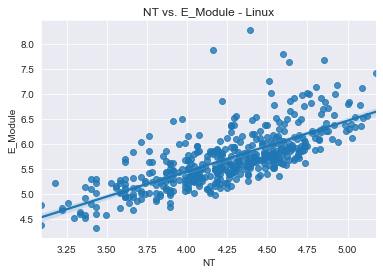

In [48]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Module", data=df)
plt.title('NT vs. E_Module - {0}'.format("Linux"))

Text(0.5, 1.0, 'NO vs. E_Module - Linux')

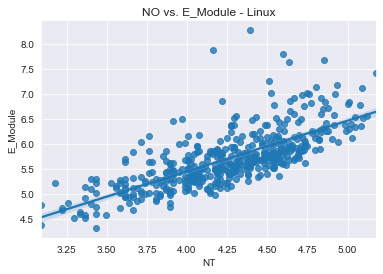

In [49]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Module", data=df)
plt.title('NO vs. E_Module - {0}'.format("Linux"))

Text(0.5, 1.0, 'T_MODULE vs. E_MODULE - Linux')

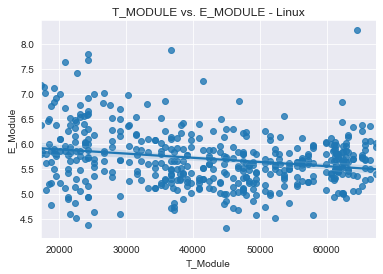

In [50]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.T_MODULE, y="E_Module", data=df)
plt.title('T_MODULE vs. E_MODULE - {0}'.format("Linux"))

In [51]:
# Let's create multiple regression
X = df[[c.NT, c.NO]]
Y = df['E_Line']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.876, test_size=0.124, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

OLS Regression Results                                
Dep. Variable:                 E_Line   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          4.191e+04
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                        0.00
Time:                        10:33:38   Log-Likelihood:                         -375.13
No. Observations:                 408   AIC:                                      754.3
Df Residuals:                     406   BIC:                                      762.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [52]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,NT,NO
vif,338.866345,338.866345


In [53]:
model.resid.mean()

0.0008612355765791966

In [54]:
print("MAE: {0}".format(metrics.mean_absolute_error(y_test, predictions)))

MAE: 0.463097752542284


Text(0.5, 1.0, 'E_Line Homoscedasticity')

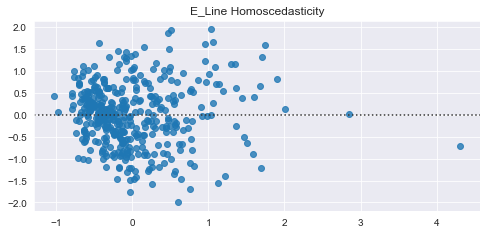

In [55]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = model.fittedvalues.copy()
true_val = y_train
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)
plt.title('E_Line Homoscedasticity')

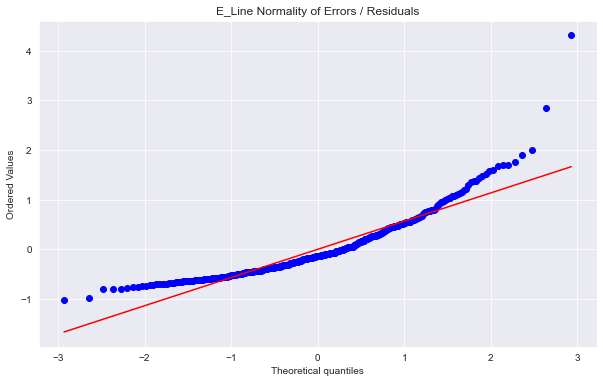

In [56]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Line Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Line Normality of Errors / Residuals')

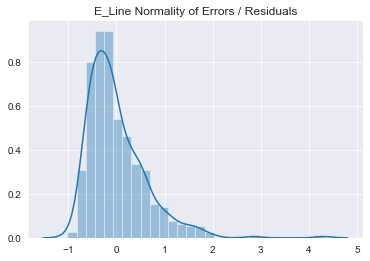

In [57]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Line Normality of Errors / Residuals')

In [58]:
results = utils.create_percent_error_df(y_test, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
591,8.04,8.38,0.35,0.04,0
467,8.60,8.92,0.32,0.04,1
188,8.58,9.22,0.64,0.08,2
126,8.01,7.91,0.10,0.01,3
515,7.59,7.65,0.05,0.01,4
32,8.74,8.16,0.58,0.07,5
333,7.99,8.23,0.24,0.03,6
383,8.15,7.72,0.43,0.05,7
350,7.88,8.11,0.23,0.03,8
319,7.43,8.32,0.88,0.12,9


In [59]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 100.00%
PRED (50): 100.00%


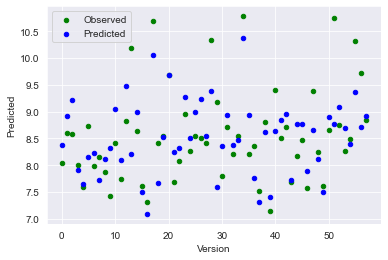

In [60]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [61]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [62]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, "NT", fig=regPlotNC)

In [63]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, "NO", fig=regPlotNO)

In [64]:
# df.plot.scatter(x=c.NT, y='E_Module', c='red')
# df.plot.scatter(x=c.NO, y='E_Module', c='green')
# df.plot.scatter(x=c.T_MODULE, y='E_Module', c='orange')
# df.plot.scatter(x=c.T_LINE, y='E_Module', c='purple')

In [65]:
# Let's create multiple regression
X = df[[c.NT, c.NO, c.T_MODULE]]
Y = df['E_Module']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.876, test_size=0.124, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)

OLS Regression Results                                
Dep. Variable:               E_Module   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.882e+04
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                        0.00
Time:                        10:33:44   Log-Likelihood:                         -51.980
No. Observations:                 408   AIC:                                      110.0
Df Residuals:                     405   BIC:                                      122.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [66]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,NT,NO,T_Module
vif,338.940928,344.855263,8.398191


In [67]:
model.resid.mean()

-0.00035650480362518316

In [68]:
print("MAE: {0}".format(metrics.mean_absolute_error(y_test, predictions)))

MAE: 0.12282724181063681


Text(0.5, 1.0, 'E_Module Homoscedasticity')

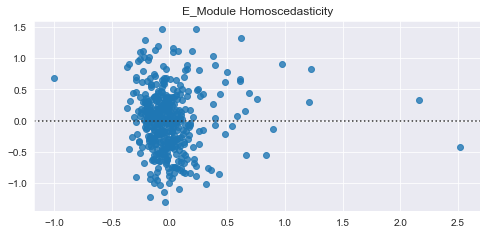

In [69]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = model.fittedvalues.copy()
true_val = y_train
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)
plt.title('E_Module Homoscedasticity')

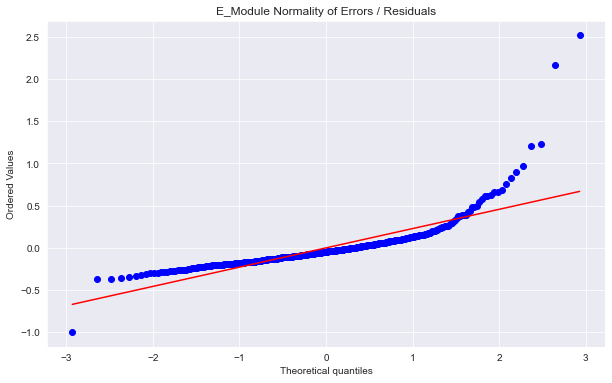

In [70]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Module Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Module Normality of Errors / Residuals')

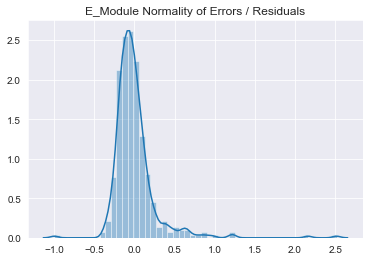

In [71]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Module Normality of Errors / Residuals')

In [72]:
results = utils.create_percent_error_df(y_test, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
591,5.40,5.42,0.02,0.00,0
467,5.83,5.72,0.10,0.02,1
188,5.88,6.18,0.31,0.05,2
126,5.16,5.30,0.14,0.03,3
515,4.73,4.85,0.12,0.03,4
32,5.49,5.50,0.01,0.00,5
333,5.26,5.36,0.09,0.02,6
383,5.21,5.18,0.03,0.01,7
350,5.30,5.33,0.03,0.01,8
319,5.12,5.32,0.19,0.04,9


In [73]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 100.00%
PRED (50): 100.00%


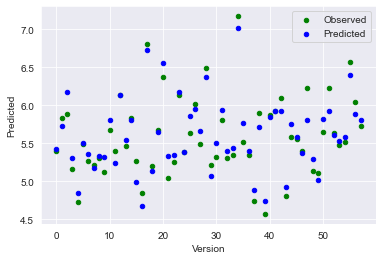

In [74]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [75]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [76]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, "NT", fig=regPlotNC)

In [77]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, "NO", fig=regPlotNO)

In [78]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.T_MODULE, fig=regPlotNO)